# CommandMap Gamification Analysis : The "No Game" Pilot



In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt

from util.survey_structure import MOTIVATION_LIKERT_COLUMNS, MOTIVATION_SHORT_LIKERT_COLUMNS, MOTIVATION_STATEMENTS


MY_DATA_PATH = "./data/noGuide.db"

# Note: this will all be reassigned to actual datasets below 
TRIAL_TABLE_NAME = "table_trialLog"
DEMOGRAPHICS = "questionnaire_demographics"
MOTIVATION_SHORT_ONE = "questionnaire_motivation_short"
MOTIVATION_SHORT_DUPLICATE = "questionnaire_motivation_short_duplicate"
MOTIVATION = "questionnaire_motivation"
PARTICIPANT = "participant"
PROGRESS = "progress"


## Read in the data

In [34]:
connection = sqlite3.connect(MY_DATA_PATH)
cursor = connection.cursor()

# reading all table names
table_list = [a for a in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

print("Your database contains the following tables:")
print(table_list)

TRIAL_DATA = pd.read_sql_query(f"SELECT *FROM {TRIAL_TABLE_NAME}", connection)
DEMOGRAPHICS = pd.read_sql_query(f"SELECT * FROM {DEMOGRAPHICS}", connection)
MOTIVATION_SHORT_ONE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_ONE}", connection)
MOTIVATION_SHORT_DUPLICATE = pd.read_sql_query(f"SELECT * FROM {MOTIVATION_SHORT_DUPLICATE}", connection)
MOTIVATION = pd.read_sql_query(f"SELECT * FROM {MOTIVATION}", connection)
PARTICIPANT = pd.read_sql_query(f"SELECT * FROM {PARTICIPANT}", connection)
PROGRESS = pd.read_sql_query(f"SELECT * FROM {PROGRESS}", connection)

connection.close()

Your database contains the following tables:
[('participant',), ('progress',), ('radio_grid_log',), ('display',), ('session_store',), ('questionnaire_motivation_short_duplicate',), ('questionnaire_motivation',), ('questionnaire_preferences',), ('questionnaire_prolific_start',), ('questionnaire_motivation_short',), ('questionnaire_demographics',), ('table_trialLog',), ('table_streamLog',)]


In [35]:
MOTIVATION_SHORT_DUPLICATE.columns

Index(['motivation_short_duplicateID', 'participantID', 'tag', 'timeStarted',
       'timeEnded', 'boring_task', 'enjoyable_task', 'satisfied_performance',
       'couldnt_do_well', 'attention', 'effort_task', 'didnt_try_hard',
       'felt_tense', 'relaxed_task'],
      dtype='object')

## Preprocessing

Of the participants who did not abandon the study, one participant timed out and another reported technical issues. There were additional records in the database generated from testing the study on the server. All of these are removed before analysis. 

After removing unusable data, there are 10 participants. 

In [36]:
# IDs 1-3: Testing
# IDs 5, 8, 13: Technical issue, did not finish, timeout

IDS_TO_REMOVE = [1, 2, 3, 5, 8, 13]

TRIAL_DATA = TRIAL_DATA[~TRIAL_DATA["participantID"].isin(IDS_TO_REMOVE)]
DEMOGRAPHICS = DEMOGRAPHICS[~DEMOGRAPHICS["participantID"].isin(IDS_TO_REMOVE)]
MOTIVATION_SHORT_ONE = MOTIVATION_SHORT_ONE[~MOTIVATION_SHORT_ONE["participantID"].isin(IDS_TO_REMOVE)]
MOTIVATION_SHORT_DUPLICATE = MOTIVATION_SHORT_DUPLICATE[~MOTIVATION_SHORT_DUPLICATE["participantID"].isin(IDS_TO_REMOVE)]
MOTIVATION = MOTIVATION[~MOTIVATION["participantID"].isin(IDS_TO_REMOVE)]
PARTICIPANT = PARTICIPANT[~PARTICIPANT["participantID"].isin(IDS_TO_REMOVE)]
PROGRESS = PROGRESS[~PROGRESS["participantID"].isin(IDS_TO_REMOVE)]



## Demographic Data Overview


All participants were familiar with Micosoft applications and did not have colour vision deficiency. One participant reported that they did not have normal visual ability but declined to specify the nature of their visual disability. 

In [37]:
DEMOGRAPHICS[["microsoftFamiliarity", "visionAbility", "CVD", "visionAblilityType"]]

,microsoftFamiliarity,visionAbility,CVD,visionAblilityType
1,Yes,Yes,No,
3,Yes,Yes,No,
4,Yes,Yes,No,
5,Yes,No,No,
6,Yes,Yes,No,
7,Yes,Yes,No,
9,Yes,No,No,
11,Yes,Yes,No,
12,Yes,Yes,No,
13,Yes,Yes,No,


The participants consisted of 8 women and 2 men. 

<AxesSubplot:xlabel='gender', ylabel='Count'>

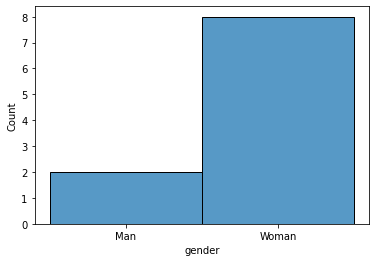

In [38]:


sns.histplot(DEMOGRAPHICS["gender"])

Ages of participants ranged from 22 to 72.

<AxesSubplot:xlabel='age', ylabel='Count'>

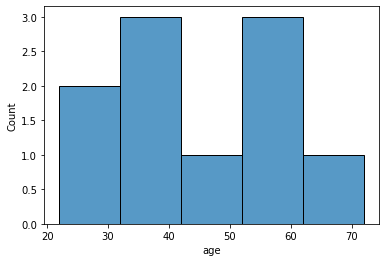

In [39]:
DEMOGRAPHICS['age'].max()
DEMOGRAPHICS['age'].min()

sns.histplot(DEMOGRAPHICS["age"])

In [40]:
DEMOGRAPHICS["occupation"]

1                Retail Manager
3                retail manager
4                    Unemployed
5                       manager
6                   Real Estate
7                Events manager
9                      Designer
11       assistant psychologist
12                      manager
13    Community Care Supervisor
Name: occupation, dtype: object

Many participants spent a fair amount of time using a computer (most were roughly between 55 and 65 hours a week.) All were familiar with Microsoft applications.

<AxesSubplot:xlabel='compUsage', ylabel='Count'>

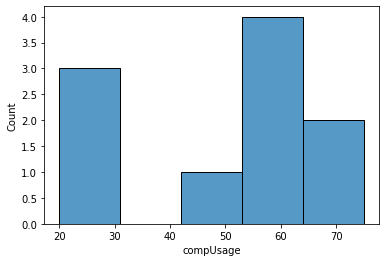

In [41]:
sns.histplot(DEMOGRAPHICS['compUsage'])

Generally, the participants were not big gamers, but most spent some of their time gaming. Six participants play games less than 3 hours per week, with three reporting that they do not generally spend time playing video games.  

In [42]:
DEMOGRAPHICS['videoGameUsage']

1      6
3      1
4      3
5     15
6      2
7      0
9      0
11     1
12     5
13     0
Name: videoGameUsage, dtype: int64

<AxesSubplot:xlabel='videoGameUsage', ylabel='Count'>

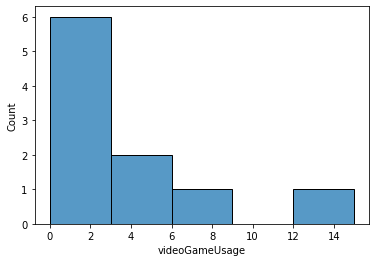

In [43]:
sns.histplot(DEMOGRAPHICS['videoGameUsage'])

## IMI Motivational Survey: First, Second, and Third Rounds



### The First Survey: including IMI, FSS, PENS and TLX 

In [46]:
# Note Side Effects: This function will alter the original dataframe (shallow copy)
def format_likert_data_for_histogram(df: pd.DataFrame, likert_columns: list) -> pd.DataFrame:
    for column_name in likert_columns:
        df[column_name] = df[column_name].replace('1 (Strongly Disagree)', '1')
        df[column_name] = df[column_name].replace('7 (Strongly Agree)', '7')
        df[column_name] = df[column_name].astype('int64')
    return df

/tmp/ipykernel_92222/3442930079.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


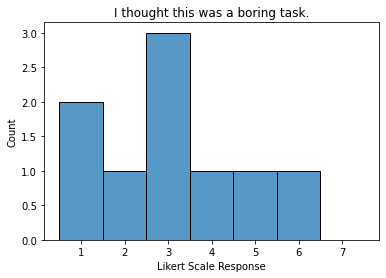

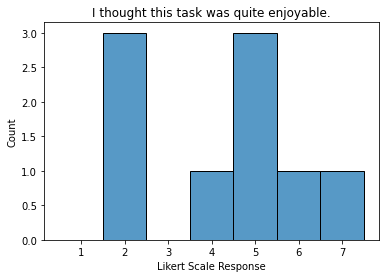

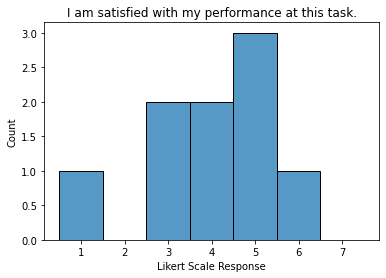

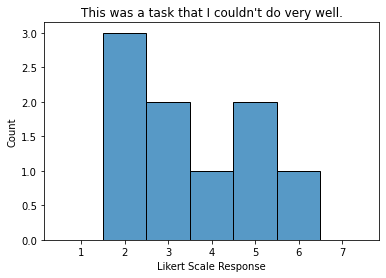

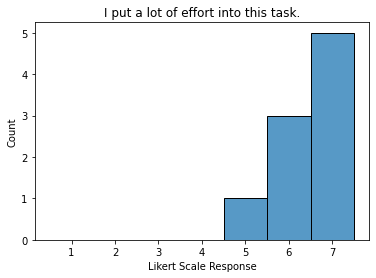

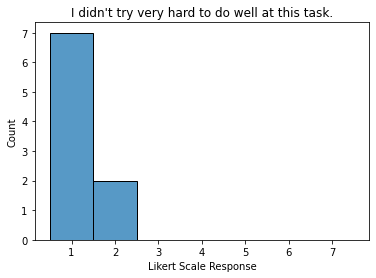

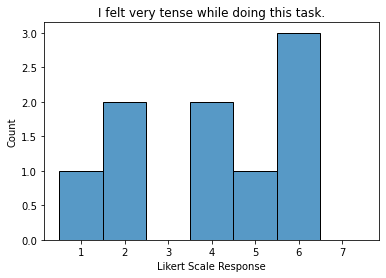

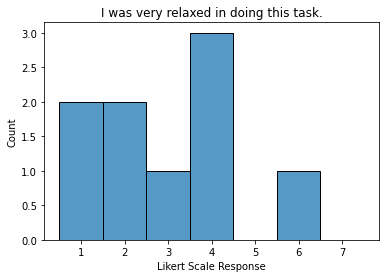

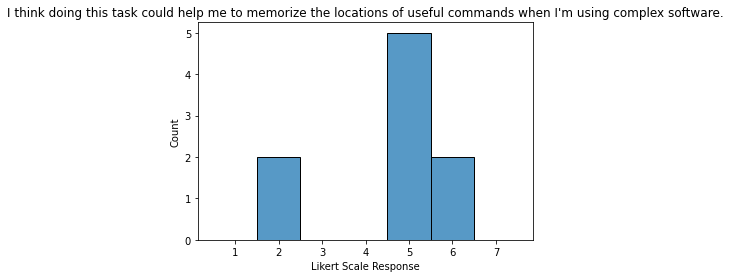

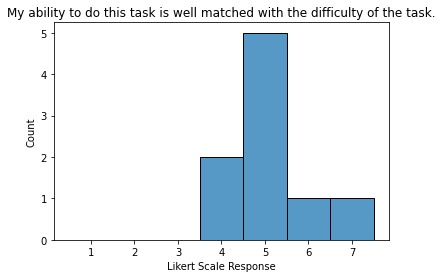

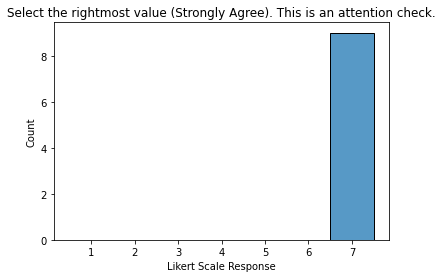

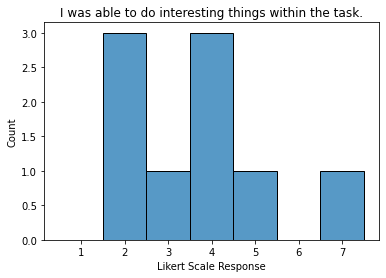

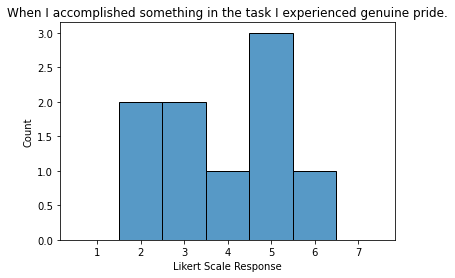

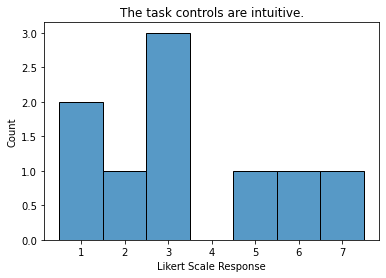

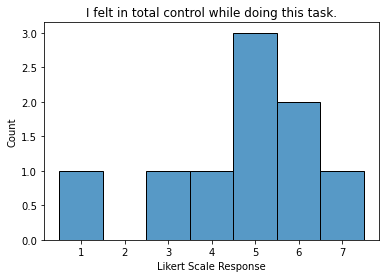

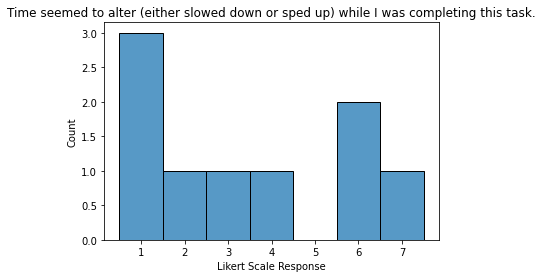

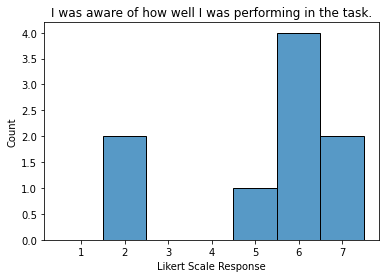

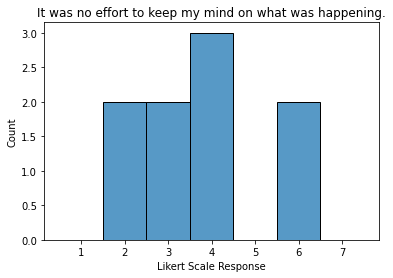

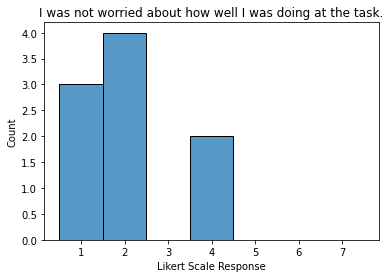

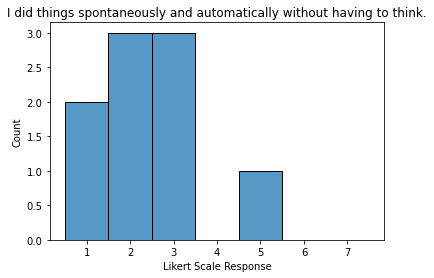

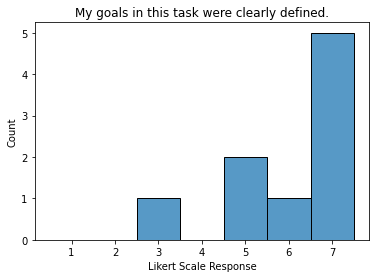

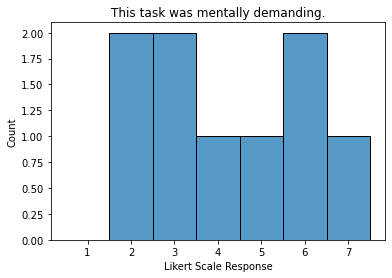

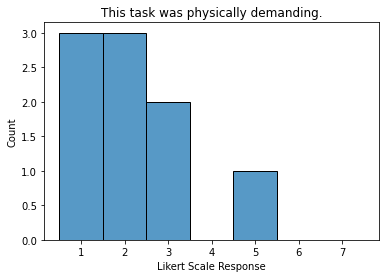

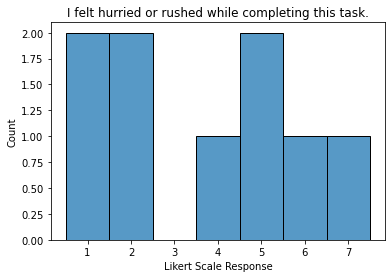

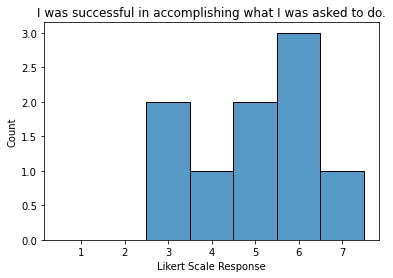

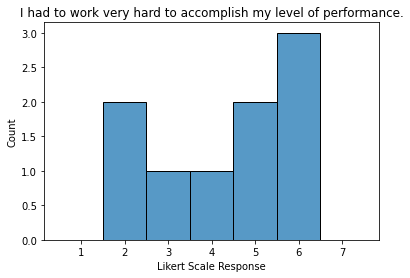

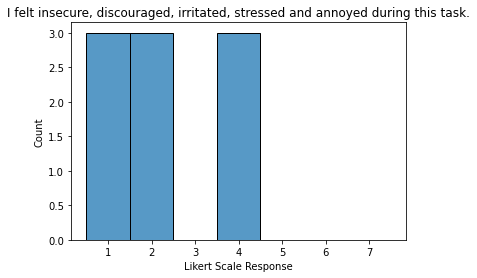

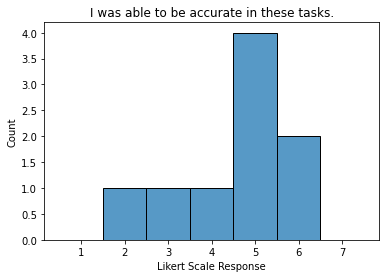

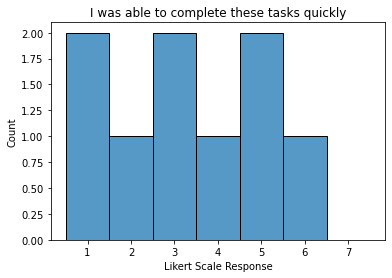

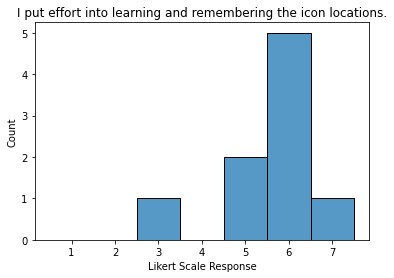

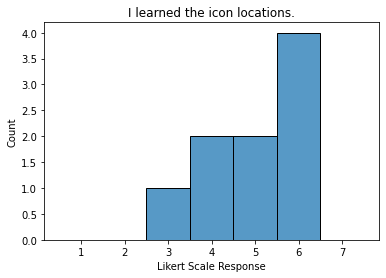

In [47]:
MOTIVATION = format_likert_data_for_histogram(MOTIVATION, MOTIVATION_LIKERT_COLUMNS)

for likert_data in MOTIVATION_LIKERT_COLUMNS:
    plt.figure()
    sns.histplot(data=MOTIVATION, x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
    plt.savefig(f"./plots/motivation_first_survey/{likert_data}.png")


### The Second Motivational Survey (IMI questions only)

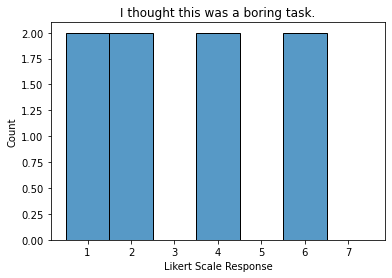

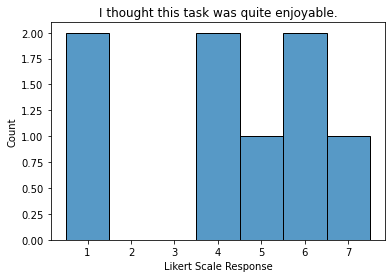

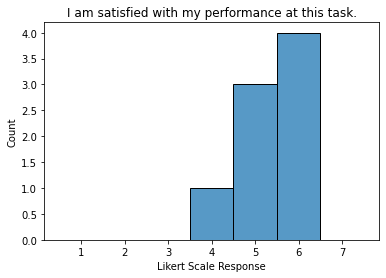

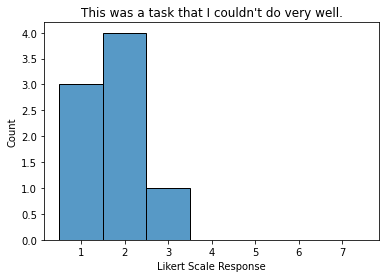

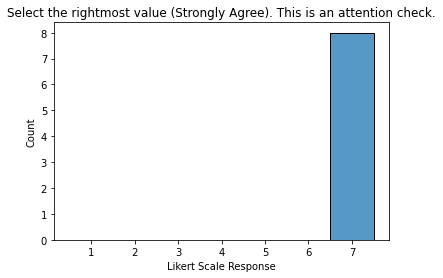

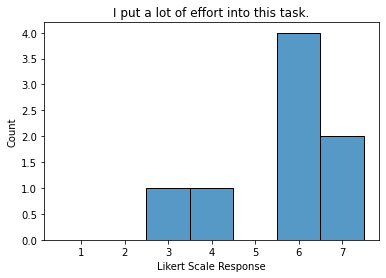

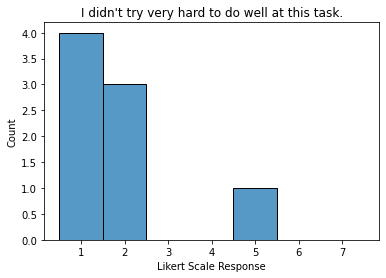

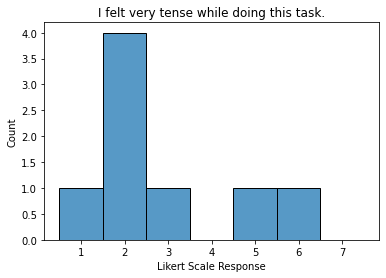

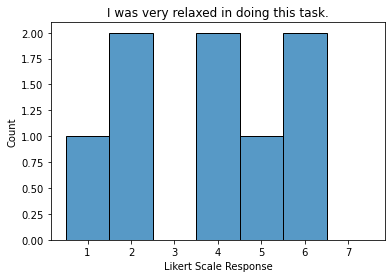

In [48]:
MOTIVATION_SHORT_ONE = format_likert_data_for_histogram(MOTIVATION_SHORT_ONE, MOTIVATION_SHORT_LIKERT_COLUMNS)

for likert_data in MOTIVATION_SHORT_LIKERT_COLUMNS:
    plt.figure()
    sns.histplot(data=MOTIVATION_SHORT_ONE, x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
    plt.savefig(f"./plots/motivation_second_survey/{likert_data}.png")

### The Third Motivational Survey (IMI questions only)

In [49]:
MOTIVATION_SHORT_DUPLICATE.columns

Index(['motivation_short_duplicateID', 'participantID', 'tag', 'timeStarted',
       'timeEnded', 'boring_task', 'enjoyable_task', 'satisfied_performance',
       'couldnt_do_well', 'attention', 'effort_task', 'didnt_try_hard',
       'felt_tense', 'relaxed_task'],
      dtype='object')

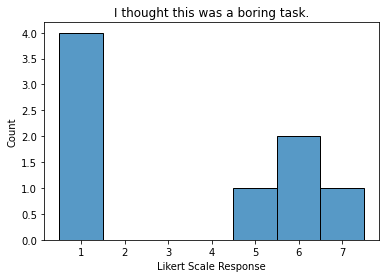

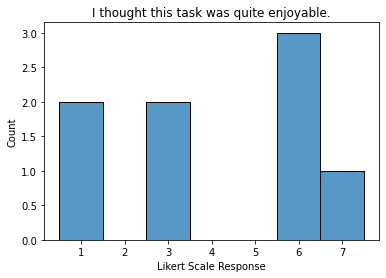

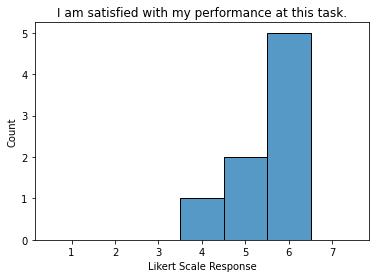

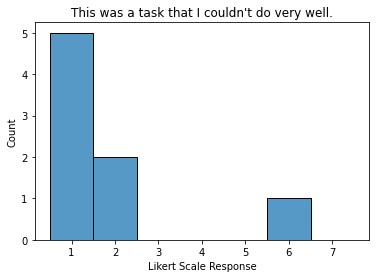

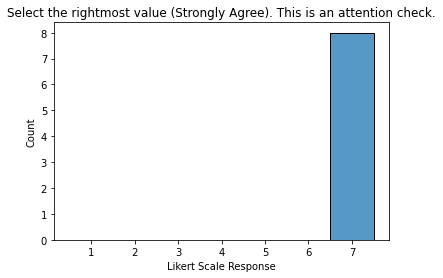

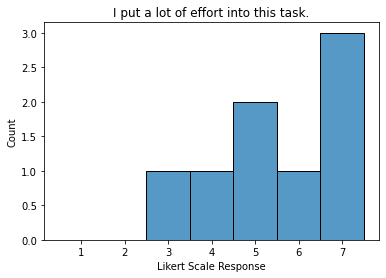

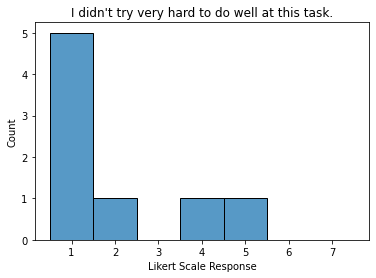

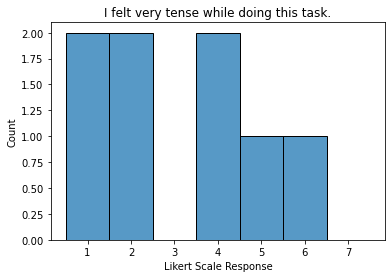

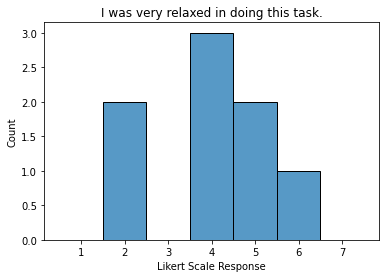

In [ ]:
MOTIVATION_SHORT_DUPLICATE = format_likert_data_for_histogram(MOTIVATION_SHORT_DUPLICATE, MOTIVATION_SHORT_LIKERT_COLUMNS)

for likert_data in MOTIVATION_SHORT_LIKERT_COLUMNS:
    plt.figure()
    sns.histplot(data=MOTIVATION_SHORT_DUPLICATE, x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
    plt.savefig(f"./plots/motivation_third_survey/{likert_data}.png")

### Combining All IMI Response at First, Second and Third Survey Intervals 

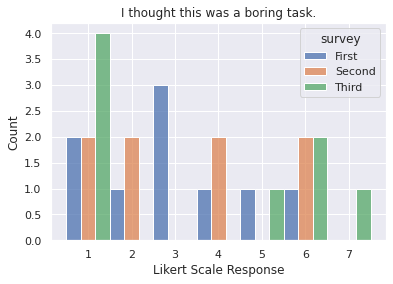

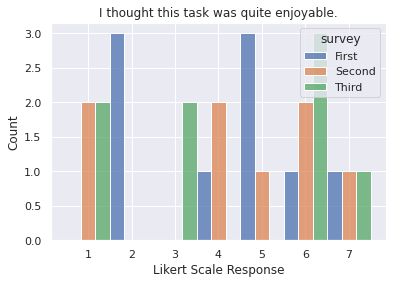

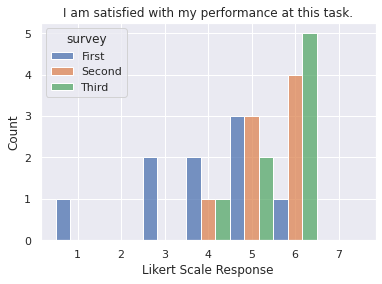

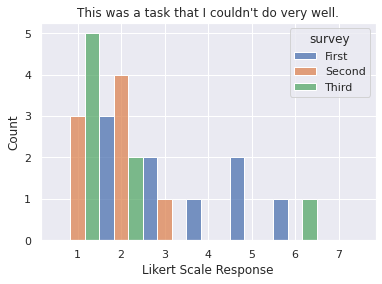

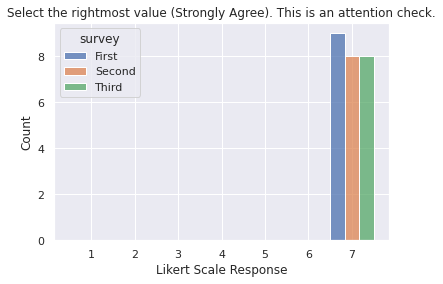

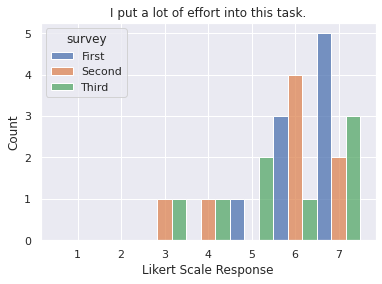

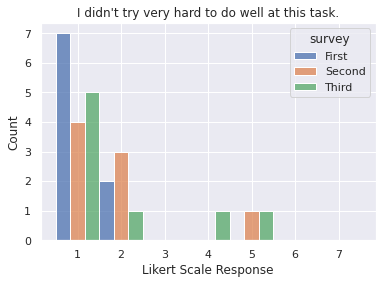

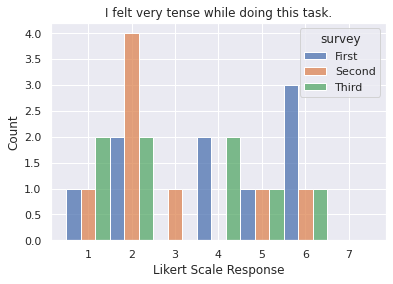

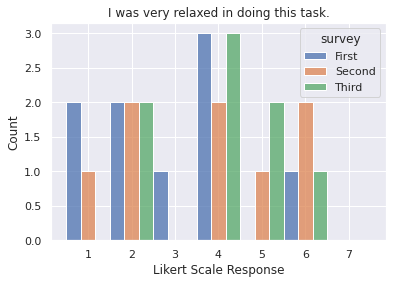

In [ ]:

# Combine the datasets

MOTIVATION['survey'] = "First"
MOTIVATION_SHORT_ONE['survey'] = "Second"
MOTIVATION_SHORT_DUPLICATE['survey'] = "Third"

all_surveys = pd.concat([MOTIVATION, MOTIVATION_SHORT_ONE, MOTIVATION_SHORT_DUPLICATE], ignore_index=True)

sns.set_theme()
for likert_data in MOTIVATION_SHORT_LIKERT_COLUMNS:
    plt.figure()
    sns.histplot(data=all_surveys, hue='survey', multiple='dodge', x=likert_data, binrange=(1, 7), discrete=True).set(title=MOTIVATION_STATEMENTS[likert_data], xlabel="Likert Scale Response", ylabel="Count")
    plt.savefig(f"./plots/motivation_third_survey/{likert_data}.png")